# *Relaxation and Decoherence* 

This notebook provides a method of running circuits and measuring hardware parameters of the $T_1$ and $T_2$ decay times for 2 connected qubits. The method of parameter extraction is through solving a Markovian quantum master equation and minimising the least-squares regression between this solution and the experimental data. The notebook is split into two main segments, the experimental circuits and collection of data, followed by the numerical solutions.

## Initialisation Cell

In [1]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

# Numerical
import jax
import numpy as np
import scipy
import jax.numpy as jnp
import jax.scipy as jsp

from jax.numpy import linalg
from jax.numpy.linalg import multi_dot
from jax import grad, jit, vmap, pmap, random, jacfwd, jacrev
from jax.ops import index, index_add, index_update
from jax.experimental.ode import odeint
from numpy import nanargmin, nanargmax
from numpy import sqrt

key = random.PRNGKey(42)

# Qiskit
import qiskit

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, IBMQ
from qiskit.compiler import transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import *
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import U1Gate, U2Gate, RXGate
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

provider = IBMQ.load_account()

# Constants and Units
from astropy import units as unts
from astropy import constants as cnts

# Extras
import smtplib, ssl
import warnings

warnings.filterwarnings("ignore")

# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
jax.local_devices()

## Connect to IBMQ

In [3]:
IBMQ.get_provider(hub='ibm-q',
                  group='open',
                  project='main')
backend = provider.get_backend('ibmq_bogota')

Initialise our parameters

In [4]:
t1l = []
t2l = []

for i in range(len(backend.properties().qubits)):
    t1l.append(backend.properties().t1(i))
    t2l.append(backend.properties().t2(i))

In [5]:
q0err = backend.properties().readout_error(0)
print(q0err)
q1err = backend.properties().readout_error(1)
print(q1err)

0.017800000000000038
0.03390000000000004


In [6]:
backend_config = backend.configuration()
backend_prop = backend.properties()

hamiltonian = backend_config.hamiltonian
w0 = hamiltonian['vars']['wq0']
w1 = hamiltonian['vars']['wq1']
w2 = hamiltonian['vars']['wq2']
w3 = hamiltonian['vars']['wq3']
w4 = hamiltonian['vars']['wq4']
j01 = hamiltonian['vars']['jq0q1']
j12 = hamiltonian['vars']['jq1q2']
j23 = hamiltonian['vars']['jq2q3']
j34 = hamiltonian['vars']['jq3q4']

In [7]:
ygate_time = (backend.properties().gate_length('sx', 0) * 2 * unts.s).to(unts.ns)
ygate_time

<Quantity 71.11111111 ns>

In [8]:
qerr = np.sqrt(q0err ** 2 + q1err ** 2) / 2
qerr

0.019144516186104077

In [9]:
xgate_time = (backend.properties().gate_length('x', 0) * unts.s).to(unts.ns)
xgate_time

<Quantity 35.55555556 ns>

In [10]:
qiskit.circuit.library.YGate(0).decompositions[0].draw()

┌───────────────┐
q_0: ┤ U3(π,π/2,π/2) ├
     └───────────────┘

In [11]:
qiskit.circuit.library.U3Gate(np.pi, np.pi/2, np.pi/2).decompositions[0].draw()

/home/dean/miniconda3/lib/python3.9/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


┌─────────┐┌────┐┌────────┐┌────┐┌──────────┐
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├
     └─────────┘└────┘└────────┘└────┘└──────────┘

In [12]:
(backend.properties().gate_length('rz', 0) * unts.s).to(unts.ns)

<Quantity 0. ns>

In [13]:
qiskit.circuit.library.U2Gate(0, 0).decompositions[0].draw()

┌─────────────┐
q_0: ┤ U3(π/2,0,0) ├
     └─────────────┘

In [14]:
qiskit.circuit.library.U3Gate(np.pi/2, 0, 0).decompositions[0].draw()

global phase: 3π/2
     ┌───────┐┌────┐┌──────────┐┌────┐┌────────┐
q_0: ┤ Rz(0) ├┤ √X ├┤ Rz(3π/2) ├┤ √X ├┤ Rz(3π) ├
     └───────┘└────┘└──────────┘└────┘└────────┘

In [15]:
t2gatetime = 3 * ygate_time
t2gatetime.to(unts.us)

<Quantity 0.21333333 us>

In [16]:
dt = (backend_config.dt * unts.s).to(unts.ns)
dt

<Quantity 0.22222222 ns>

In [17]:
((4 * unts.us) / dt).to(unts.dimensionless_unscaled) * 2

<Quantity 36000.>

In [18]:
dt_times = np.linspace(0, 1332000, 75)
dt_times[:3]

array([    0., 18000., 36000.])

In [19]:
(dt_times[-3:] * dt).to(unts.us)

<Quantity [288., 292., 296.] us>

With some helper functions

In [20]:
def expt(T, w):
    """
    This function computes the average number of photons, n, depending on the frequency, w, and the temperature, T.
    Inputs:
    T - Temperature (in Kelvin)
    w - Frequency (in Hz)
    Outputs:
    n - Average photon number
    """
    n = 1/(jnp.exp((cnts.hbar.value * w)/(cnts.k_B.value * T)) - 1)
    return float(n)

In [21]:
def T(w, n):
    """
    This function computes the temperature, T, depending on the frequency, w, and the average number of photons, n.
    Inputs:
    T - Temperature (in Kelvin)
    n - Average photon number
    Outputs:
    w - Frequency (in Hz)
    """
    return cnts.hbar.value * w/(cnts.k_B.value * jnp.log(1/n + 1)) * unts.K

As well as some ansatze for the other parameters, based on the latest configuration $T_1$ & $T_2$ times and the claimed qubit temperatures of 15 mK.

In [22]:
n1 = expt(15e-3, w0)
n2 = expt(15e-3, w1)

t1c = jnp.array(t1l)
t2c = jnp.array(t2l)

g1l = 1/t1c
g2l = 1/t2c

## Generation of coherence circuits

This shows how to generate the circuits. The list of qubits specifies for which qubits to generate characterization circuits; these circuits will run in parallel. The discrete unit of time is the Delay gate, which instructs the circuit to do nothing for a specified amount of time.

In [23]:
time = np.linspace(0, 74*4, 75)
tie = np.linspace(0, 74, 75)

qubits = [0, 1]
shots = 8192

n = len(qubits)
N = 2 ** n

qr = qiskit.QuantumRegister(max(qubits)+1)
cr = qiskit.ClassicalRegister(len(qubits))

nosc = 5

osc_freq = nosc/time[-1]

In [24]:
cool = pl.cm.cool(np.linspace(0, 1, N))
plasma = pl.cm.plasma(np.linspace(0, 1, N + 1))
magma = pl.cm.magma(np.linspace(0, 1, N))
winter = pl.cm.winter(np.linspace(0, 1, N))

In [25]:
def pad_id_gates(circuit, qr, qubit, num_of_id_gates):
    """
    A function for padding a circuit with single-qubit delay gates.
    Args:
        circuit (QuantumCircuit): the quantum circuit that the gates should be
            appended to
        qr (QuantumRegister): the qubit register where the gates should be added
        qubit (int): index of qubit where the gates should be added
        num_of_id_gates (int): the number of delay gates to add
    Returns:
        circuit: The original circuit object, but with delay
            gates added to the qubit register qr at qubit 'qubit'
    """
    
    circuit.barrier(qr[qubit])
    num_of_id_gates = int(num_of_id_gates)
    circuit.delay(num_of_id_gates, qr[qubit], unit = 'dt')

    circuit.barrier(qr[qubit])
    return circuit

In [26]:
qiskit.circuit.Delay(10, unit='dt')

Delay(duration=10[unit=dt])

### T1 Circuits $|11\rangle$

In [27]:
t1circuits_11 = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    circ.reset(qr[qubits[0]])
    circ.reset(qr[qubits[1]])
    circ.x(qr[qubits[0]])
    circ.x(qr[qubits[1]])
    circ.barrier(qr[qubits])
    circ = pad_id_gates(circ, qr, qubits[0], circ_length)
    circ = pad_id_gates(circ, qr, qubits[1], circ_length)
    circ.measure(qr[qubits[0]], cr[0])
    circ.measure(qr[qubits[1]], cr[1])
    t1circuits_11.append(circ)

t1circuits_11[-1].draw()

┌───┐ ░  ░ ┌────────────────────┐ ░ ┌─┐   
q0_0: ─|0>─┤ X ├─░──░─┤ Delay(1332000[dt]) ├─░─┤M├───
           ├───┤ ░  ░ ├────────────────────┤ ░ └╥┘┌─┐
q0_1: ─|0>─┤ X ├─░──░─┤ Delay(1332000[dt]) ├─░──╫─┤M├
           └───┘ ░  ░ └────────────────────┘ ░  ║ └╥┘
c0: 2/══════════════════════════════════════════╩══╩═
                                                0  1

### T1 Circuits $|10\rangle$

In [28]:
t1circuits_10 = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    circ.reset(qr[qubits[0]])
    circ.reset(qr[qubits[1]])
    circ.x(qr[qubits[0]])
    circ.barrier(qr[qubits])
    circ = pad_id_gates(circ, qr, qubits[0], circ_length)
    circ = pad_id_gates(circ, qr, qubits[1], circ_length)
    circ.measure(qr[qubits[0]], cr[0])
    circ.measure(qr[qubits[1]], cr[1])
    t1circuits_10.append(circ)

t1circuits_10[-1].draw()

┌───┐ ░  ░ ┌────────────────────┐ ░ ┌─┐   
q0_0: ─|0>─┤ X ├─░──░─┤ Delay(1332000[dt]) ├─░─┤M├───
           └───┘ ░  ░ ├────────────────────┤ ░ └╥┘┌─┐
q0_1: ─|0>───────░──░─┤ Delay(1332000[dt]) ├─░──╫─┤M├
                 ░  ░ └────────────────────┘ ░  ║ └╥┘
c0: 2/══════════════════════════════════════════╩══╩═
                                                0  1

### T1 Circuits $|01\rangle$

In [29]:
t1circuits_01 = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    circ.reset(qr[qubits[0]])
    circ.reset(qr[qubits[1]])
    circ.x(qr[qubits[1]])
    circ.barrier(qr[qubits])
    circ = pad_id_gates(circ, qr, qubits[0], circ_length)
    circ = pad_id_gates(circ, qr, qubits[1], circ_length)
    circ.measure(qr[qubits[0]], cr[0])
    circ.measure(qr[qubits[1]], cr[1])
    t1circuits_01.append(circ)

t1circuits_01[-1].draw()

░  ░ ┌────────────────────┐ ░ ┌─┐   
q0_0: ─|0>───────░──░─┤ Delay(1332000[dt]) ├─░─┤M├───
           ┌───┐ ░  ░ ├────────────────────┤ ░ └╥┘┌─┐
q0_1: ─|0>─┤ X ├─░──░─┤ Delay(1332000[dt]) ├─░──╫─┤M├
           └───┘ ░  ░ └────────────────────┘ ░  ║ └╥┘
c0: 2/══════════════════════════════════════════╩══╩═
                                                0  1

### T1 Circuits $|00\rangle$

In [30]:
t1circuits_00 = []

for circ_index, circ_length in enumerate(dt_times):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    circ.reset(qr[qubits[0]])
    circ.reset(qr[qubits[1]])
    circ.barrier(qr[qubits])
    circ = pad_id_gates(circ, qr, qubits[0], circ_length)
    circ = pad_id_gates(circ, qr, qubits[1], circ_length)
    circ.measure(qr[qubits[0]], cr[0])
    circ.measure(qr[qubits[1]], cr[1])
    t1circuits_00.append(circ)

t1circuits_00[-1].draw()

░  ░ ┌────────────────────┐ ░ ┌─┐   
q0_0: ─|0>──░──░─┤ Delay(1332000[dt]) ├─░─┤M├───
            ░  ░ ├────────────────────┤ ░ └╥┘┌─┐
q0_1: ─|0>──░──░─┤ Delay(1332000[dt]) ├─░──╫─┤M├
            ░  ░ └────────────────────┘ ░  ║ └╥┘
c0: 2/═════════════════════════════════════╩══╩═
                                           0  1

### Readout Error Mitigation

In [31]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits, qr=qr, circlabel='mcal')

## Backend Execution

In [32]:
# Run the Readout Error Mitigation circuits
cal_results = qiskit.execute(meas_calibs, backend = backend, shots = shots).result()

In [33]:
# Run the T1 11 circuits
t1_backend_result_11 = qiskit.execute(t1circuits_11, backend, shots = shots, optimization_level = 0).result()

In [34]:
# Run the T1 10 circuits
t1_backend_result_10 = qiskit.execute(t1circuits_10, backend, shots = shots, optimization_level = 0).result()

In [35]:
# Run the T1 01 circuits
t1_backend_result_01 = qiskit.execute(t1circuits_01, backend, shots = shots, optimization_level = 0).result()

In [36]:
# Run the T1 00 circuits
t1_backend_result_00 = qiskit.execute(t1circuits_00, backend, shots = shots, optimization_level = 0).result()

Let's look at the calibration results

Average Measurement Fidelity: 0.942749


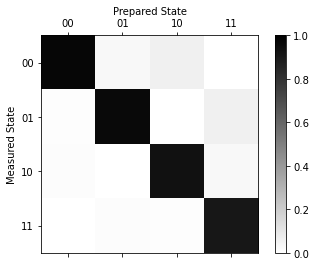

In [37]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = 'mcal')
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())
meas_fitter.plot_calibration()

Apply the error mitigation

In [38]:
# Results without mitigation

t1_raw_counts_11 = t1_backend_result_11.get_counts(0)
t1_raw_counts_10 = t1_backend_result_10.get_counts(0)
t1_raw_counts_01 = t1_backend_result_01.get_counts(0)
t1_raw_counts_00 = t1_backend_result_00.get_counts(0)

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation

t1_mitigated_results_11 = meas_filter.apply(t1_backend_result_11)
t1_mitigated_results_10 = meas_filter.apply(t1_backend_result_10)
t1_mitigated_results_01 = meas_filter.apply(t1_backend_result_01)
t1_mitigated_results_00 = meas_filter.apply(t1_backend_result_00)

t1_mitigated_counts_11 = t1_mitigated_results_11.get_counts(0)
t1_mitigated_counts_10 = t1_mitigated_results_10.get_counts(0)
t1_mitigated_counts_01 = t1_mitigated_results_01.get_counts(0)
t1_mitigated_counts_00 = t1_mitigated_results_00.get_counts(0)

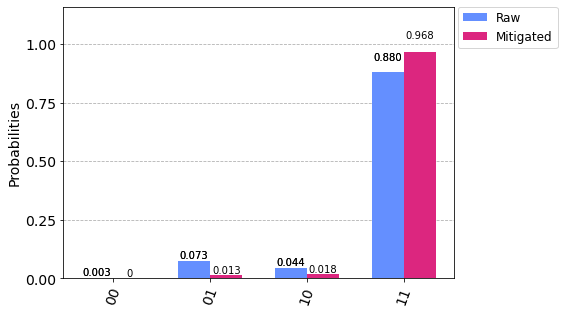

In [39]:
# T1 11 Mitigated Counts
plot_histogram([t1_raw_counts_11, t1_mitigated_counts_11], legend = ['Raw', 'Mitigated'])

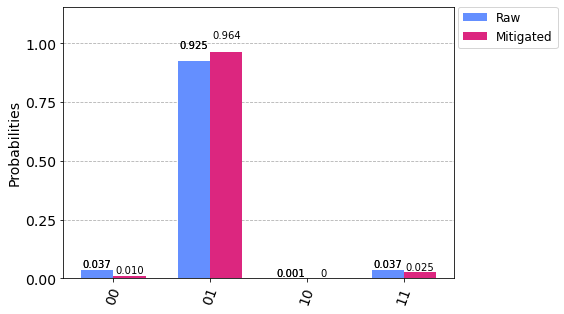

In [40]:
# T1 10 Mitigated Counts
plot_histogram([t1_raw_counts_10, t1_mitigated_counts_10], legend = ['Raw', 'Mitigated'])

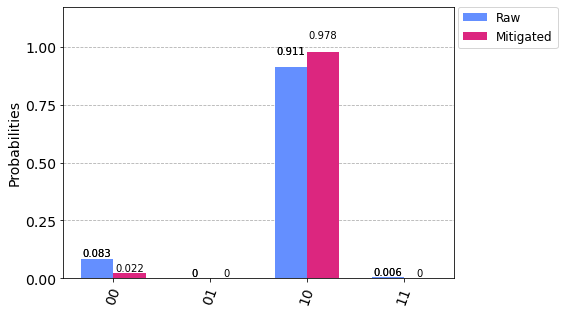

In [41]:
# T1 01 Mitigated Counts
plot_histogram([t1_raw_counts_01, t1_mitigated_counts_01], legend = ['Raw', 'Mitigated'])

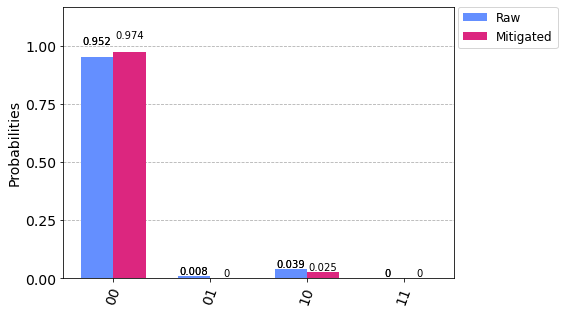

In [42]:
# T1 00 Mitigated Counts
plot_histogram([t1_raw_counts_00, t1_mitigated_counts_00], legend = ['Raw', 'Mitigated'])

## Data Fitting

In [43]:
def extract_counts(back_res):
    lst00, lst01, lst10, lst11 = [], [], [], []


    for i in range(len(time)):
        if '11' in back_res.get_counts(i):
            i11 = back_res.get_counts(i)['11']
        else:
            i11 = 0
        if '10' in back_res.get_counts(i):
            i10 = back_res.get_counts(i)['10']
        else:
            i10 = 0
        if '01' in back_res.get_counts(i):
            i01 = back_res.get_counts(i)['01']
        else:
            i01 = 0
        if '00' in back_res.get_counts(i):
            i00 = back_res.get_counts(i)['00']
        else:
            i00 = 0

        q00 = i00/shots
        q01 = i01/shots
        q10 = i10/shots
        q11 = i11/shots

        lst00.append(q00)
        lst01.append(q01)
        lst10.append(q10)
        lst11.append(q11)
    
    return [lst00, lst01, lst10, lst11]

In [44]:
# T1 11 Raw

t1raw_lst00_11, t1raw_lst01_11, t1raw_lst10_11, t1raw_lst11_11 = extract_counts(t1_backend_result_11)

# T1 11 Mitigated

t1mit_lst00_11, t1mit_lst01_11, t1mit_lst10_11, t1mit_lst11_11 = extract_counts(t1_mitigated_results_11)

# T1 10 Raw

t1raw_lst00_10, t1raw_lst01_10, t1raw_lst10_10, t1raw_lst11_10 = extract_counts(t1_backend_result_10)

# T1 10 Mitigated

t1mit_lst00_10, t1mit_lst01_10, t1mit_lst10_10, t1mit_lst11_10 = extract_counts(t1_mitigated_results_10)

# T1 01 Raw

t1raw_lst00_01, t1raw_lst01_01, t1raw_lst10_01, t1raw_lst11_01 = extract_counts(t1_backend_result_01)

# T1 01 Mitigated

t1mit_lst00_01, t1mit_lst01_01, t1mit_lst10_01, t1mit_lst11_01 = extract_counts(t1_mitigated_results_01)

# T1 00 Raw

t1raw_lst00_00, t1raw_lst01_00, t1raw_lst10_00, t1raw_lst11_00 = extract_counts(t1_backend_result_00)

# T1 00 Mitigated

t1mit_lst00_00, t1mit_lst01_00, t1mit_lst10_00, t1mit_lst11_00 = extract_counts(t1_mitigated_results_00)

## Plot the $T_1 |11\rangle$ Results

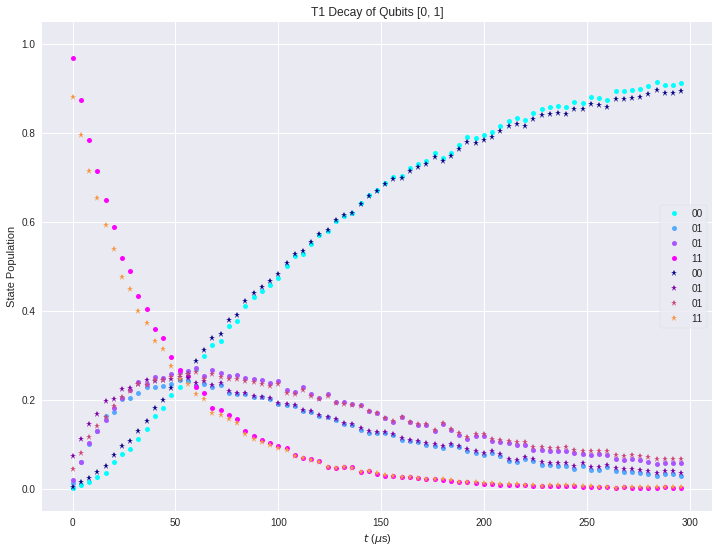

In [45]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T1 Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t1mit_lst00_11, label = "00", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_11, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_11, label = "01", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst11_11, label = "11", marker='.', markersize=10, linestyle='', c = cool[3])

plt.plot(time, t1raw_lst00_11, label = "00", marker='*', markersize=7, linestyle='', c = plasma[0])
plt.plot(time, t1raw_lst01_11, label = "01", marker='*', markersize=7, linestyle='', c = plasma[1])
plt.plot(time, t1raw_lst10_11, label = "01", marker='*', markersize=7, linestyle='', c = plasma[2])
plt.plot(time, t1raw_lst11_11, label = "11", marker='*', markersize=7, linestyle='', c = plasma[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_1 |10\rangle$ Results

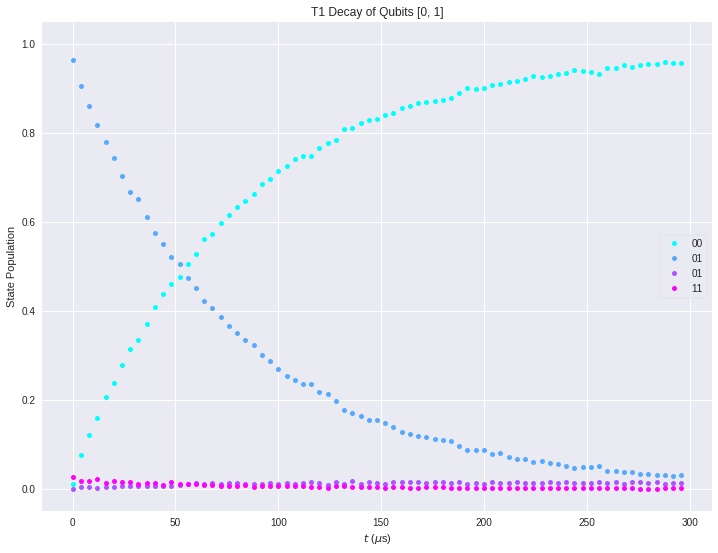

In [46]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T1 Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t1mit_lst00_10, label = "00", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_10, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_10, label = "01", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst11_10, label = "11", marker='.', markersize=10, linestyle='', c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_1 |01\rangle$ Results

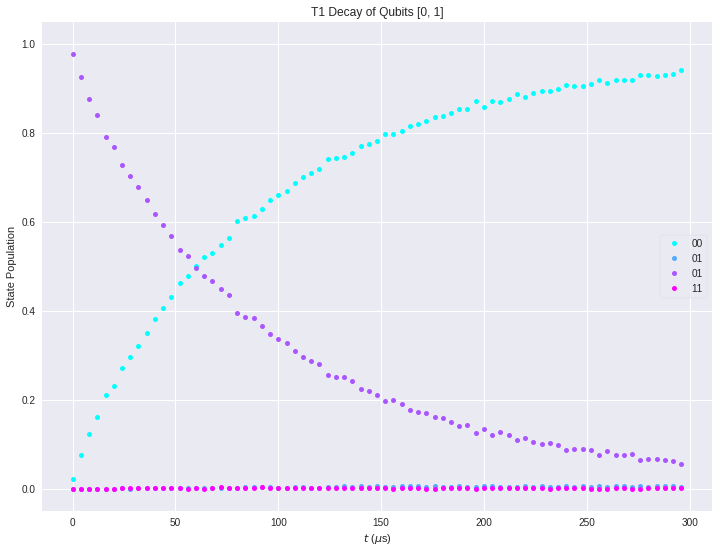

In [47]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T1 Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t1mit_lst00_01, label = "00", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_01, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_01, label = "01", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst11_01, label = "11", marker='.', markersize=10, linestyle='', c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_1 |00\rangle$ Results



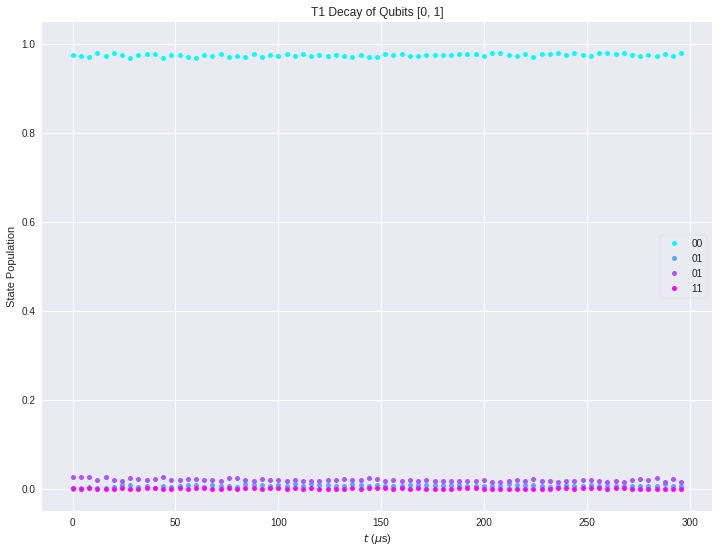

In [48]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T1 Decay of Qubits ' + str(qubits))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t1mit_lst00_00, label = "00", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_00, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_00, label = "01", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst11_00, label = "11", marker='.', markersize=10, linestyle='', c = cool[3])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

In [153]:
import csv

In [157]:
rows_t1r_11_00 = zip(time, t1mit_lst00_11)
rows_t1r_11_10 = zip(time, t1mit_lst10_11)
rows_t1r_11_01 = zip(time, t1mit_lst01_11)
rows_t1r_11_11 = zip(time, t1mit_lst11_11)

with open('Q2_T1_i11_raw00.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_11_00:
        writer.writerow(row)

with open('Q2_T1_i11_raw10.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_11_10:
        writer.writerow(row)

with open('Q2_T1_i11_raw01.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_11_01:
        writer.writerow(row)

with open('Q2_T1_i11_raw11.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_11_11:
        writer.writerow(row)

In [158]:
rows_t1r_10_00 = zip(time, t1mit_lst00_10)
rows_t1r_10_10 = zip(time, t1mit_lst10_10)
rows_t1r_10_01 = zip(time, t1mit_lst01_10)
rows_t1r_10_11 = zip(time, t1mit_lst11_10)

with open('Q2_T1_i10_raw00.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_10_00:
        writer.writerow(row)

with open('Q2_T1_i10_raw10.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_10_10:
        writer.writerow(row)

with open('Q2_T1_i10_raw01.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_10_01:
        writer.writerow(row)

with open('Q2_T1_i10_raw11.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_10_11:
        writer.writerow(row)

In [159]:
rows_t1r_01_00 = zip(time, t1mit_lst00_01)
rows_t1r_01_10 = zip(time, t1mit_lst10_01)
rows_t1r_01_01 = zip(time, t1mit_lst01_01)
rows_t1r_01_11 = zip(time, t1mit_lst11_01)

with open('Q2_T1_i01_raw00.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_01_00:
        writer.writerow(row)

with open('Q2_T1_i01_raw10.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_01_10:
        writer.writerow(row)

with open('Q2_T1_i01_raw01.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_01_01:
        writer.writerow(row)

with open('Q2_T1_i01_raw11.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1r_01_11:
        writer.writerow(row)

# Numerical Solutions

In [49]:
sz = jnp.array([[1,0],[0,-1]], dtype = jnp.complex64)
sx = jnp.array([[0,1],[1,0]], dtype = jnp.complex64)
sy = jnp.array([[0, -1j],[1j, 0]], dtype = jnp.complex64)

zero = jnp.array([1, 0], dtype = jnp.complex64)
one = jnp.array([0, 1], dtype = jnp.complex64)
plus = 1/jnp.sqrt(2) * jnp.array([1, 1], dtype = jnp.complex64)
minus = 1/jnp.sqrt(2) * jnp.array([1, -1], dtype = jnp.complex64)
right = 1/jnp.sqrt(2) * (zero + 1j * one)
left = 1/jnp.sqrt(2) * (zero - 1j * one)

sp = jnp.outer(zero, one)
sm = jnp.outer(one, zero)

id2 = jnp.identity(2, dtype = jnp.complex64)
id3 = jnp.identity(3, dtype = jnp.complex64)
id4 = jnp.kron(id2, id2)

sz1 = jnp.kron(sz, id2)
sx1 = jnp.kron(sx, id2)
sy1 = jnp.kron(sy, id2)
sp1 = jnp.kron(sp, id2)
sm1 = jnp.kron(sm, id2)

sz2 = jnp.kron(id2, sz)
sx2 = jnp.kron(id2, sx)
sy2 = jnp.kron(id2, sy)
sp2 = jnp.kron(id2, sp)
sm2 = jnp.kron(id2, sm)

sv1 = jnp.array([sx1, sy1, sz1])
sv2 = jnp.array([sx2, sy2, sz2])

O1 = (jnp.identity(4) - sz1)/2
O2 = (jnp.identity(4) - sz2)/2

H2 = 1/jnp.sqrt(2) * jnp.array([[1, 1],
                                [1, -1]], dtype = jnp.complex64)

H4 = np.kron(H2, H2)

def ugate(t, p, l):
    u = jnp.array([[jnp.cos(t/2), - jnp.exp(1j * l) * jnp.sin(t/2)],
                  [jnp.exp(1j * p) * jnp.sin(t/2), jnp.exp(1j * (p + l)) * jnp.cos(t/2)]], dtype = jnp.complex64)
    return u

def u1gate(l):
    u = jnp.array([[1, 0],
                  [0, jnp.exp(1j * l)]], dtype = jnp.complex64)
    return u

def u2gate(p, l):
    u = 1/jnp.sqrt(2) * jnp.array([[1, -jnp.exp(1j * l)],
                                   [jnp.exp(1j * p), jnp.exp(1j * (p + l))]], dtype = jnp.complex64)
    return u

def dagger(A):
    return jnp.transpose(jnp.conjugate(A))

Y90 = jnp.kron(u2gate(0, 0), u2gate(0, 0))

X = jnp.kron(sx, sx)
Y = jnp.kron(sy, sy)

xdata = time / 1e6

In [50]:
def jdot(jmat, smat):
    jsum = []
    for i in range(len(smat)):
        rsum = []
    for j in range(len(smat)):
        rsum.append(jmat[i, j] * smat[j])
    jsum.append(sum(rsum))
    return jnp.array(jsum)

We will solve the following equation. The Quantum Master equation for a two-qubit system undergoing thermal relaxation and decoherence:
$$\frac{d \rho}{dt}=\mathcal{L}\rho,$$
where
$$\mathcal{L}\rho =-\imath[H,\rho]+\gamma_1(\langle n_1 \rangle +1)\left(\sigma_-^1\rho\sigma_+^1+\frac{1}{2}\left\{\sigma_+^1\sigma_-^1,\rho\right\}\right) + \gamma_1(\langle n_1 \rangle)\left(\sigma_+^1\rho\sigma_-^1+\frac{1}{2}\left\{\sigma_-^1\sigma_+^1,\rho\right\}\right) \\ + \gamma_2(\langle n_2 \rangle +1)\left(\sigma_-^2\rho\sigma_+^2+\frac{1}{2}\left\{\sigma_+^2\sigma_-^2,\rho\right\}\right) + \gamma_2(\langle n_2 \rangle)\left(\sigma_+^2\rho\sigma_-^2+\frac{1}{2}\left\{\sigma_-^2\sigma_+^2,\rho\right\}\right)$$

and
$$
H = \frac{\omega_1}{2}\sigma_z^1 + \frac{\omega_2}{2}\sigma_z^2 + J\left(\sigma_+^1\sigma_-^2 + \sigma_-^1\sigma_+^2\right)
$$

$$
\gamma_1^1 = \gamma\left(\langle n_1 \rangle + 1\right)  \qquad\qquad \gamma_2^1 = \gamma\left(\langle n_1 \rangle\right)
$$

$$
\gamma_1^2 = \gamma\left(\langle n_2 \rangle + 1\right)  \qquad\qquad \gamma_2^2 = \gamma\left(\langle n_2 \rangle\right)
$$

$$
\langle n_x \rangle=\frac{1}{e^{\hbar\omega_x/kT}-1} \qquad\qquad x \in \{1, 2\}
$$

The initial condition of the $T_1$ solution is:
$$\rho(0)=|00\rangle\langle 00|,$$
where 
$$|0\rangle=\left(\begin{matrix}
1\\
0
\end{matrix}\right)$$

$$
\rho_0 = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

The initial condition for the $T_2^*$ solution is:
$$\rho(0)=|++\rangle\langle ++|,$$
where 
$$|+\rangle=\frac{1}{\sqrt{2}}\left(\begin{matrix}
1\\
1
\end{matrix}\right)$$

$$
\rho_0 = \frac{1}{4} \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 \\
\end{pmatrix}
$$

In [51]:
init_11 = jnp.array(jnp.outer(jnp.kron(one, one), jnp.kron(one, one)), dtype = jnp.complex64)

init_10 = jnp.array(jnp.outer(jnp.kron(one, zero), jnp.kron(one, zero)), dtype = jnp.complex64)

init_01 = jnp.array(jnp.outer(jnp.kron(zero, one), jnp.kron(zero, one)), dtype = jnp.complex64)

init_00 = jnp.array(jnp.outer(jnp.kron(zero, zero), jnp.kron(zero, zero)), dtype = jnp.complex64)

In [52]:
xdata = time / 1e6
xd = time/1e3
qtime = jnp.linspace(0, 0.075, 75)
prmsl = [w0, w1, g1l[0], g1l[1], j01, n1, n2]
# prms1 = jnp.array([w0, w1, g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([2 * w0, w1, 2 * g2l[0] * 1e6, 2 * g2l[1] * 1e6, j01 * 1e3, n1, n2]) / 1e9
# prms2e = jnp.array([w0, w1, g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9

# prms1 = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([6 * g2l[0] * 1e6, 6 * g2l[1] * 1e6, j01, n1, n2]) / 1e9
# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9
# prms2e = jnp.array([g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9


prmsC = jnp.array([0, 0, w0, 0, 0, w1, j01/2, 0, 0, 0, j01/2, 0, 0, 0, 0, g1l[0] * 1e6, g1l[1] * 1e6, n1, n2]) / 1e9
prmsHC = jnp.array([0, 0, w0, 0, 0, w1, j01/2 * 1e4, 0, 0, 0, j01/2 * 1e4, 0, 0, 0, 0, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prms2C = jnp.array([0, 0, w0, 0, 0, w1, j01/2, 0, 0, 0, j01/2, 0, 0, 0, 0, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prms1 = jnp.array([w0, w0, w0, w1, w1, w1, j01/2, j01/2, j01/2, j01/2, j01/2, j01/2, j01/2, j01/2, j01/2, g1l[0] * 1e6, g1l[1] * 1e6, n1, n2]) / 1e9
prms2s = jnp.array([w0, w0, w0, w1, w1, w1, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prms2e = jnp.array([w0, w0, w0, w1, w1, w1, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, j01/2 * 1e3, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9
prmsl_hc = jnp.array([w0, w0, w0, w1, w1, w1, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, j01/2 * 1e4, g2l[0] * 1e6, g2l[1] * 1e6, n1, n2]) / 1e9

## Define the Master Equation Solvers

In [53]:
jdot(id3, sv2).shape

(1, 4, 4)

In [54]:
sv1.shape

(3, 4, 4)

In [55]:
sjs = 0
for i in range(3):
    sjs += jnp.dot(sv1[i], jdot(id3, sv2)[i])
sjs

DeviceArray([[ 1.+0.j,  0.+0.j,  1.-1.j,  0.+0.j],
             [ 0.+0.j, -1.+0.j,  0.+0.j, -1.+1.j],
             [ 1.+1.j,  0.+0.j, -1.+0.j,  0.+0.j],
             [ 0.+0.j, -1.-1.j,  0.+0.j,  1.+0.j]], dtype=complex64)

In [56]:
ve = jnp.array([1, 1, 1])
sum(jnp.dot(ve[i], sv1[i]))

array([ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j], dtype=complex64)

In [57]:
vesum = []
for i in range(len(sv1)):
    vesum.append(ve[i] * sv1[i])
jnp.array(sum(vesum))

DeviceArray([[ 1.+0.j,  0.+0.j,  1.-1.j,  0.+0.j],
             [ 0.+0.j,  1.+0.j,  0.+0.j,  1.-1.j],
             [ 1.+1.j,  0.+0.j, -1.+0.j,  0.+0.j],
             [ 0.+0.j,  1.+1.j,  0.+0.j, -1.+0.j]], dtype=complex64)

In [58]:
jc = jnp.ones([3, 3])
jc = id3

jc = jnp.array([[1/2, 0, 0],
                [0, 1/2, 0],
                [0, 0, 0]])

sjs = 0
for i in range(3):
    sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
sjs - (jnp.dot(sp1, sm2) + jnp.dot(sm1, sp2))

DeviceArray([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
             [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
             [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]], dtype=complex64)

In [59]:
# Function for the T1 Solution

@jit
def func_t1(r, inrho, wx0, wy0, wz0, wx1, wy1, wz1, jxx, jxy, jxz, jyx, jyy, jyz, jzx, jzy, jzz, cg1, cg2, pn1, pn2):

    W0 = jnp.array([wx0, wy0, wz0])
    W1 = jnp.array([wx1, wy1, wz1])
    jc = jnp.array([[jxx, jxy, jxy],
                    [jyx, jyy, jyz],
                    [jzx, jzy, jzz]])
    
    sjs = 0
    ws0 = []
    ws1 = []

    for i in range(3):
        sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])
    
    for i in range(3):
        ws0.append(W0[i]/2 * sv1[i])
        ws1.append(W1[i]/2 * sv2[i])
    ws0 = jnp.array(sum(ws0))
    ws1 = jnp.array(sum(ws1))

    def LinEm(x, t, omega0 = ws0, omega1 = ws1, gamma1 = cg1, gamma2 = cg2, J = sjs, N1 = pn1, N2 = pn2):
        x = x.reshape(4,4)
        H = omega0 + omega1 + J
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(N1 + 1)*(multi_dot([sm1,x,sp1])-0.5*multi_dot([sp1,sm1,x])-0.5*multi_dot([x,sp1,sm1]))
        res += gamma1*(N1)*(multi_dot([sp1,x,sm1])-0.5*multi_dot([sm1,sp1,x])-0.5*multi_dot([x,sm1,sp1]))
        res += gamma2*(N2 + 1)*(multi_dot([sm2,x,sp2])-0.5*multi_dot([sp2,sm2,x])-0.5*multi_dot([x,sp2,sm2]))
        res += gamma2*(N2)*(multi_dot([sp2,x,sm2])-0.5*multi_dot([sm2,sp2,x])-0.5*multi_dot([x,sm2,sp2]))   
        return res.ravel().astype(jnp.complex64)

    sol = jnp.zeros((len(r),4,4),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = inrho.ravel(),
                                    t = r).reshape(len(r), 4, 4), dtype=jnp.complex64)

    for step in range(len(r)):
        sol = index_update(sol,
                           index[step],
                           solint[step])

    return sol

## Plot the solutions

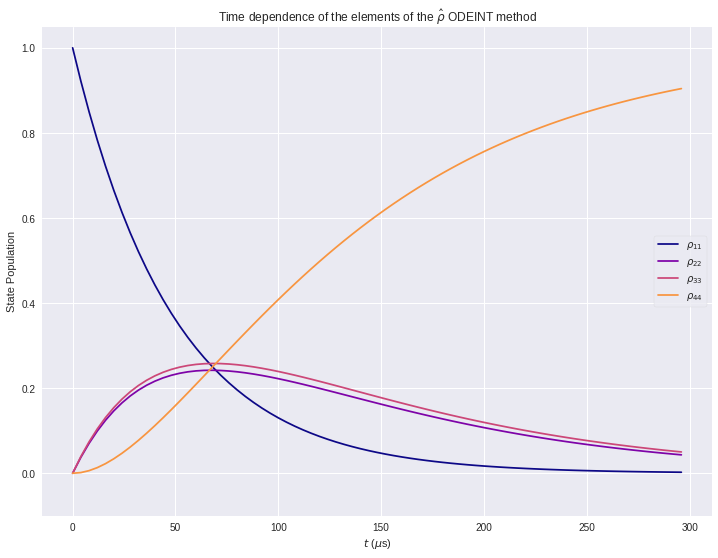

In [60]:
# T1 11 Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T1Sols_11 = func_t1(xd, init_00, *prmsC)

plt.plot(time, T1Sols_11[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T1Sols_11[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T1Sols_11[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T1Sols_11[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('Time dependence of the elements of the '+r'$\hat{\rho}$'+' ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

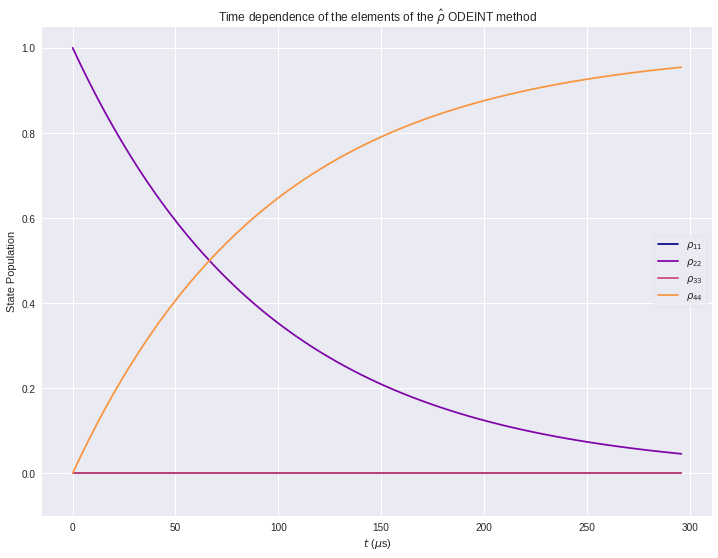

In [61]:
# T1 10 Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T1Sols_10 = func_t1(xd, init_01, *prmsC)

plt.plot(time, T1Sols_10[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T1Sols_10[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T1Sols_10[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T1Sols_10[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('Time dependence of the elements of the '+r'$\hat{\rho}$'+' ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

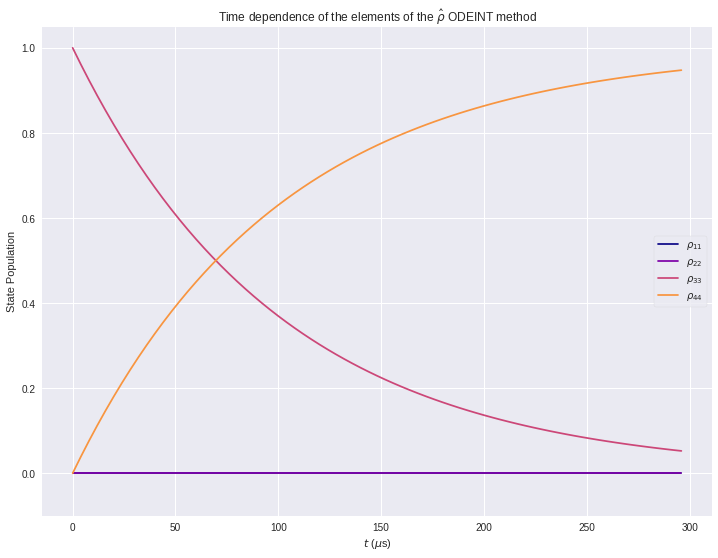

In [62]:
# T1 01 Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T1Sols_01 = func_t1(xd, init_10, *prmsC)

plt.plot(time, T1Sols_01[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T1Sols_01[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T1Sols_01[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T1Sols_01[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('Time dependence of the elements of the '+r'$\hat{\rho}$'+' ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

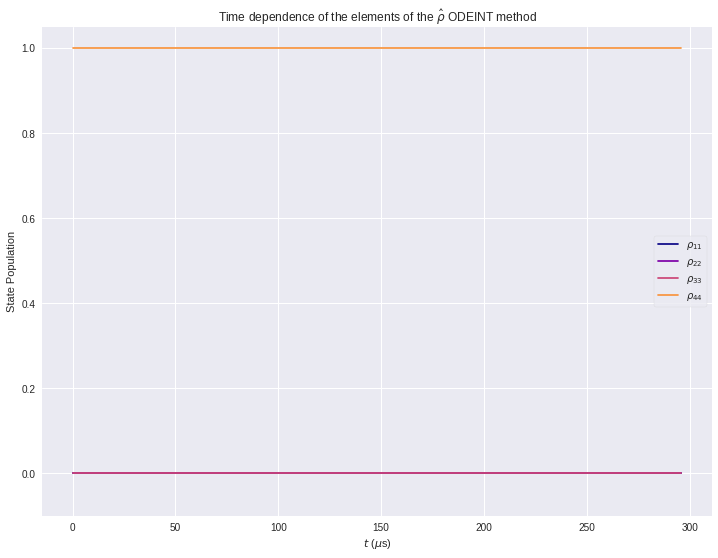

In [63]:
# T1 00 Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T1Sols_00 = func_t1(xd, init_11, *prmsC)

plt.plot(time, T1Sols_00[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T1Sols_00[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])
plt.plot(time, T1Sols_00[:, 2, 2], label = r'$\rho_{33}$', color = plasma[2])
plt.plot(time, T1Sols_00[:, 3, 3], label = r'$\rho_{44}$', color = plasma[3])

plt.title('Time dependence of the elements of the '+r'$\hat{\rho}$'+' ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Compare the device parameters to the experimental results

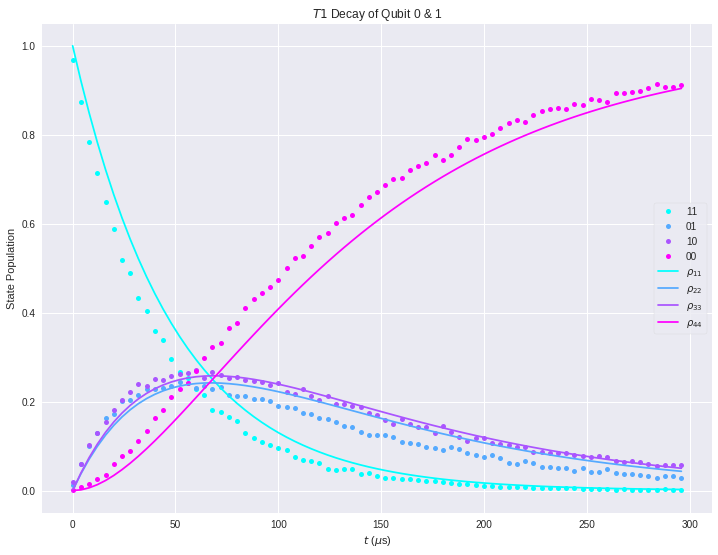

In [64]:
# T1 11 Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1mit_lst11_11, label = "11", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_11, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_11, label = "10", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst00_11, label = "00", marker='.', markersize=10, linestyle='', c = cool[3])

plt.plot(time, T1Sols_11[:, 0, 0], label = r'$\rho_{11}$', color = cool[0])
plt.plot(time, T1Sols_11[:, 1, 1], label = r'$\rho_{22}$', color = cool[1])
plt.plot(time, T1Sols_11[:, 2, 2], label = r'$\rho_{33}$', color = cool[2])
plt.plot(time, T1Sols_11[:, 3, 3], label = r'$\rho_{44}$', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

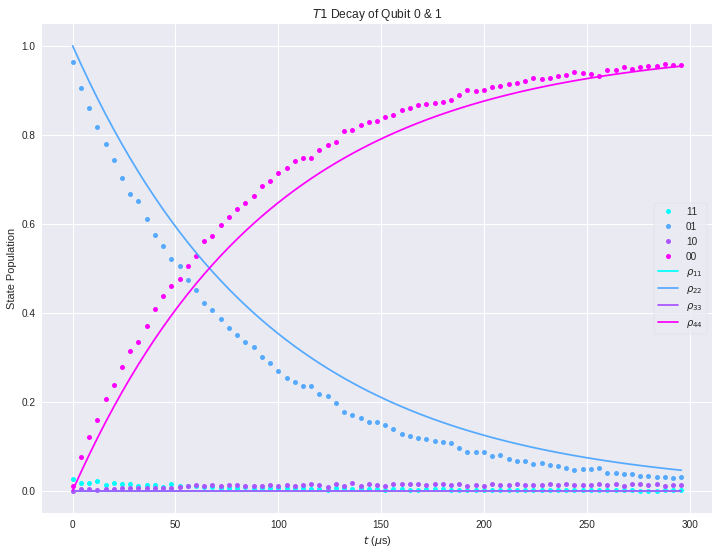

In [65]:
# T1 10 Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1mit_lst11_10, label = "11", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_10, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_10, label = "10", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst00_10, label = "00", marker='.', markersize=10, linestyle='', c = cool[3])

plt.plot(time, T1Sols_10[:, 0, 0], label = r'$\rho_{11}$', color = cool[0])
plt.plot(time, T1Sols_10[:, 1, 1], label = r'$\rho_{22}$', color = cool[1])
plt.plot(time, T1Sols_10[:, 2, 2], label = r'$\rho_{33}$', color = cool[2])
plt.plot(time, T1Sols_10[:, 3, 3], label = r'$\rho_{44}$', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

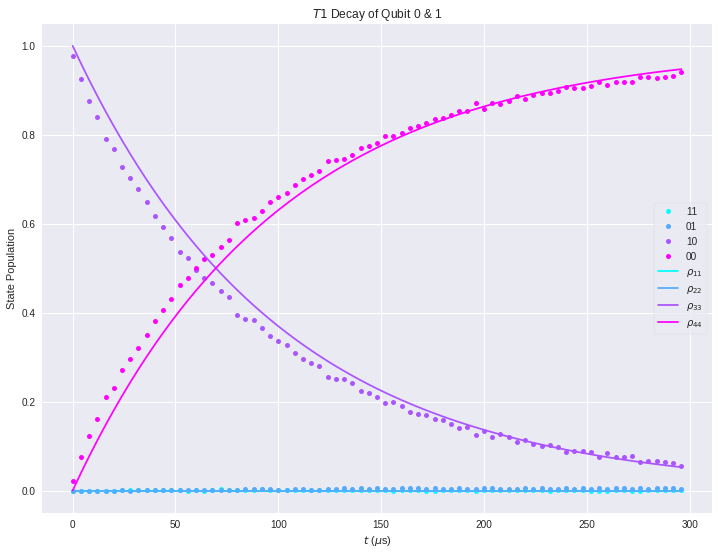

In [66]:
# T1 01 Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1mit_lst11_01, label = "11", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_01, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_01, label = "10", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst00_01, label = "00", marker='.', markersize=10, linestyle='', c = cool[3])

plt.plot(time, T1Sols_01[:, 0, 0], label = r'$\rho_{11}$', color = cool[0])
plt.plot(time, T1Sols_01[:, 1, 1], label = r'$\rho_{22}$', color = cool[1])
plt.plot(time, T1Sols_01[:, 2, 2], label = r'$\rho_{33}$', color = cool[2])
plt.plot(time, T1Sols_01[:, 3, 3], label = r'$\rho_{44}$', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

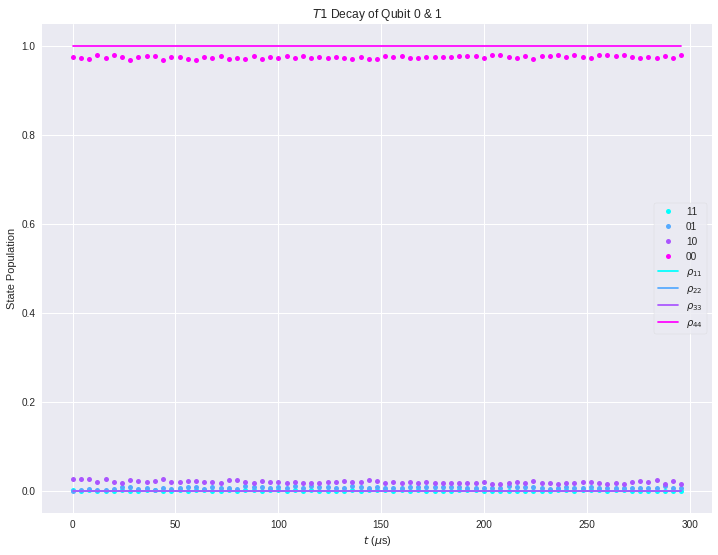

In [67]:
# T1 00 Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1mit_lst11_00, label = "11", marker='.', markersize=10, linestyle='', c = cool[0])
plt.plot(time, t1mit_lst01_00, label = "01", marker='.', markersize=10, linestyle='', c = cool[1])
plt.plot(time, t1mit_lst10_00, label = "10", marker='.', markersize=10, linestyle='', c = cool[2])
plt.plot(time, t1mit_lst00_00, label = "00", marker='.', markersize=10, linestyle='', c = cool[3])

plt.plot(time, T1Sols_00[:, 0, 0], label = r'$\rho_{11}$', color = cool[0])
plt.plot(time, T1Sols_00[:, 1, 1], label = r'$\rho_{22}$', color = cool[1])
plt.plot(time, T1Sols_00[:, 2, 2], label = r'$\rho_{33}$', color = cool[2])
plt.plot(time, T1Sols_00[:, 3, 3], label = r'$\rho_{44}$', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Data Optimisation

In [68]:
# Least Squares Function

def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return mse

In [69]:
def reg(observations, estimates):
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return r2

In [70]:
# Minimise the LstSqrs Function

def minmse_11(y):
    Y = y[0]
    
    rhot1 = func_t1(xd, init_00, *Y)
    
    t1data = jnp.array(t1mit_lst11_11, dtype=jnp.float64)
    t2data = jnp.array(t1mit_lst01_11, dtype=jnp.float64)
    t3data = jnp.array(t1mit_lst10_11, dtype=jnp.float64)
    t4data = jnp.array(t1mit_lst00_11, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot1[:, 0, 0]
    tst2 = rhot1[:, 1, 1]
    tst3 = rhot1[:, 2, 2]
    tst4 = rhot1[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

def minmse_10(y):
    Y = y[0]
    
    rhot1 = func_t1(xd, init_01, *Y)
    
    t1data = jnp.array(t1mit_lst11_10, dtype=jnp.float64)
    t2data = jnp.array(t1mit_lst01_10, dtype=jnp.float64)
    t3data = jnp.array(t1mit_lst10_10, dtype=jnp.float64)
    t4data = jnp.array(t1mit_lst00_10, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot1[:, 0, 0]
    tst2 = rhot1[:, 1, 1]
    tst3 = rhot1[:, 2, 2]
    tst4 = rhot1[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

def minmse_01(y):
    Y = y[0]
    
    rhot1 = func_t1(xd, init_10, *Y)
    
    t1data = jnp.array(t1mit_lst11_01, dtype=jnp.float64)
    t2data = jnp.array(t1mit_lst01_01, dtype=jnp.float64)
    t3data = jnp.array(t1mit_lst10_01, dtype=jnp.float64)
    t4data = jnp.array(t1mit_lst00_01, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot1[:, 0, 0]
    tst2 = rhot1[:, 1, 1]
    tst3 = rhot1[:, 2, 2]
    tst4 = rhot1[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

def minmse_00(y):
    Y = y[0]
    
    rhot1 = func_t1(xd, init_11, *Y)
    
    t1data = jnp.array(t1mit_lst11_00, dtype=jnp.float64)
    t2data = jnp.array(t1mit_lst01_00, dtype=jnp.float64)
    t3data = jnp.array(t1mit_lst10_00, dtype=jnp.float64)
    t4data = jnp.array(t1mit_lst00_00, dtype=jnp.float64)
    tdata = [t1data, t2data, t3data, t4data]
    
    tst1 = rhot1[:, 0, 0]
    tst2 = rhot1[:, 1, 1]
    tst3 = rhot1[:, 2, 2]
    tst4 = rhot1[:, 3, 3]
    tstd = [tst1, tst2, tst3, tst4]
    
    return mse(tdata, tstd)

In [71]:
minmse_11(jnp.array([prmsC]))

1.0159516522544436

In [72]:
minmse_10(jnp.array([prmsC]))

1.081801138643641

In [73]:
minmse_01(jnp.array([prmsC]))

0.2877142597717466

In [74]:
minmse_00(jnp.array([prmsC]))

0.19906972360331565

## $T_1 |11\rangle$

In [75]:
# Define an adam gradient descent optimiser

minfunc_11 = vmap(minmse_11)

scorelst_11 = []
tlst = []

# bounds = jnp.array([w0, w1, g1l[0], g1l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack_11(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bound
    first = x
    best = x
    worst = x
    score = minfunc_11(jnp.array([[x]]))
    # score = minmse(jnp.array([x]))
    scbest = score
    print('f(%s) = %f' % (x, score))

    J = jacrev(minmse_11)

    m = jnp.zeros(len(prms1))
    v = jnp.zeros(len(prms1))

    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]

        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2

        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))

        x = x - alpha * mhat / (sqrt(vhat) + eps)

        for i in range(len(x)):
            if x[i] < 0:
                x = index_update(x, index[i], bound[i])

        if scbest > minmse_11(jnp.array([x])):
            best = x
            scbest = minmse_11(jnp.array([best]))

        # evaluate candidate point
        score = minfunc_11(jnp.array([[x]]))
        # score = minmse_11(jnp.array([x]))
        scorelst_11.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest]

In [76]:
# bnds = prms1
bnds = prmsC
# bnds = best
# bnds = prmsl_hc

In [77]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 500
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best_11, score_11 = adam_jack_11(bnds, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best_11, score_11))

f([0.0000000e+00 0.0000000e+00 3.1418673e+01 0.0000000e+00 0.0000000e+00
 3.0472517e+01 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0424436e+01 9.9552593e+00 1.1266179e-16 1.8239736e-16]) = 1.015951


2021-11-23 13:39:59.511845: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_func_t1__2.3769
********************************


>0 => 0.898238
>1 => 0.793300
>2 => 0.699546
>3 => 0.617278
>4 => 0.545937
>5 => 0.489830
>6 => 0.428860
>7 => 0.371759
>8 => 0.335403
>9 => 0.285502
>10 => 0.256915
>11 => 0.221913
>12 => 0.198588
>13 => 0.174235
>14 => 0.155974
>15 => 0.139200
>16 => 0.125056
>17 => 0.113964
>18 => 0.104431
>19 => 0.097663
>20 => 0.091061
>21 => 0.085303
>22 => 0.081826
>23 => 0.077644
>24 => 0.075946
>25 => 0.072944
>26 => 0.071837
>27 => 0.070134
>28 => 0.068445
>29 => 0.067471
>30 => 0.066438
>31 => 0.065464
>32 => 0.065378
>33 => 0.064231
>34 => 0.064638
>35 => 0.064056
>36 => 0.068180
>37 => 0.075790
>38 => 0.099769
>39 => 0.118635
>40 => 0.121322
>41 => 0.070107
>42 => 0.069140
>43 => 0.086954
>44 => 0.071928
>45 => 0.062417
>46 => 0.069405
>47 => 0.070555
>48 => 0.062113
>49 => 0.064612
>50 => 0.065205
>51 => 0.063314
>52 => 0.062930
>53 => 0.061910
>54 => 0.062966
>55 => 0.063115
>56 => 0.062383
>57 => 0.063038
>58 => 0.062170
>59 => 0.062433
>60 => 0.062036
>61 => 0.062132
>62 => 0.062372
>6

>489 => 0.066719
>490 => 0.067963
>491 => 0.067714
>492 => 0.067669
>493 => 0.066708
>494 => 0.067613
>495 => 0.067004
>496 => 0.067799
>497 => 0.067095
>498 => 0.067627
>499 => 0.066673
>500 => 0.067654
Done!
f([0.0000000e+00 0.0000000e+00 3.1418673e+01 0.0000000e+00 0.0000000e+00
 3.0472517e+01 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.2654188e+01 1.1349442e+01 1.0650074e-02 4.5245282e-02]) = 0.061910


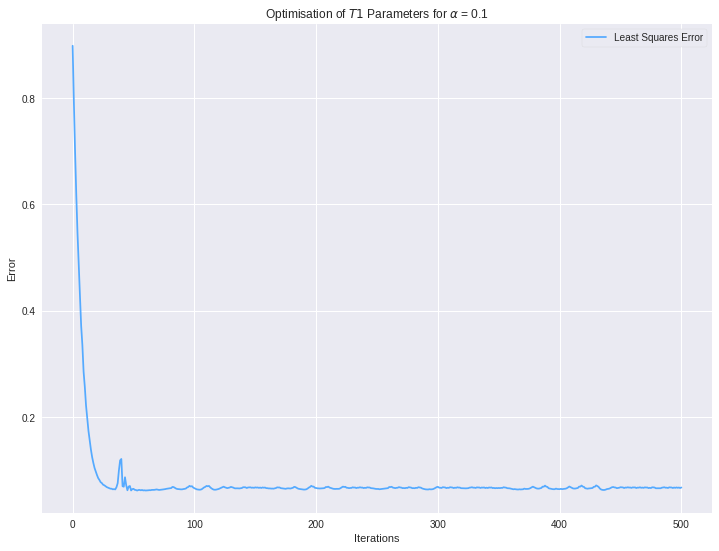

In [78]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(tlst, scorelst_11, label = 'Least Squares Error', color = cool[1])

plt.title('Optimisation of $T1$ Parameters for ' + r'$\alpha$' + ' = ' + str(alpha))
plt.xlabel('Iterations')
plt.ylabel('Error')
# plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

### Plot the fitted results

In [79]:
t1_best_11 = func_t1(xd, init_00, *best_11)

In [80]:
#R2 Regression

np.round(reg([jnp.array(t1mit_lst11_11, dtype=jnp.float64), jnp.array(t1mit_lst01_11, dtype=jnp.float64), jnp.array(t1mit_lst10_11, dtype=jnp.float64), jnp.array(t1mit_lst00_11, dtype=jnp.float64)],
    [t1_best_11[:, 0, 0], t1_best_11[:, 1, 1], t1_best_11[:, 2, 2], t1_best_11[:, 3, 3]]), 2)

99.79

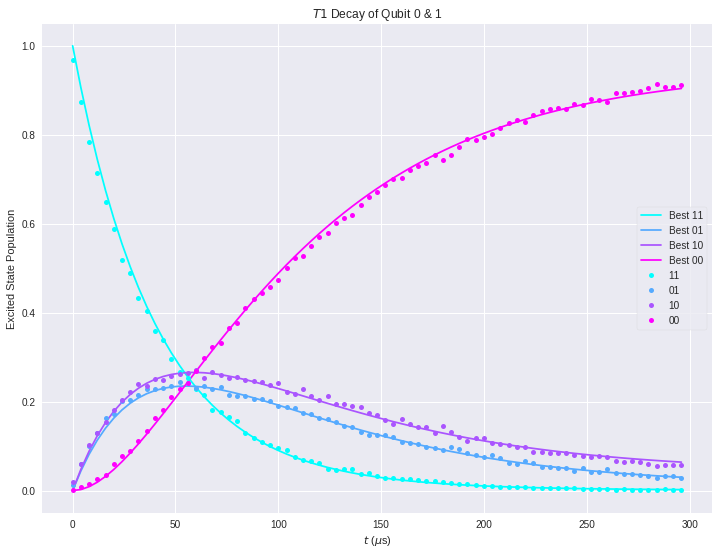

In [81]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1_best_11[:, 0, 0], label = 'Best 11', color = cool[0])
plt.plot(time, t1_best_11[:, 1, 1], label = 'Best 01', color = cool[1])
plt.plot(time, t1_best_11[:, 2, 2], label = 'Best 10', color = cool[2])
plt.plot(time, t1_best_11[:, 3, 3], label = 'Best 00', color = cool[3])

plt.plot(time, t1mit_lst11_11, label = '11', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst01_11, label = '01', marker='.', markersize=10, linestyle='', color = cool[1])
plt.plot(time, t1mit_lst10_11, label = '10', marker='.', markersize=10, linestyle='', color = cool[2])
plt.plot(time, t1mit_lst00_11, label = '00', marker='.', markersize=10, linestyle='', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## $T_1 |10\rangle$

In [82]:
# Define an adam gradient descent optimiser

minfunc_10 = vmap(minmse_10)

scorelst_10 = []
tlst = []

# bounds = jnp.array([w0, w1, g1l[0], g1l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack_10(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bound
    first = x
    best = x
    worst = x
    score = minfunc_10(jnp.array([[x]]))
    # score = minmse(jnp.array([x]))
    scbest = score
    print('f(%s) = %f' % (x, score))

    J = jacrev(minmse_10)

    m = jnp.zeros(len(prms1))
    v = jnp.zeros(len(prms1))

    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]

        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2

        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))

        x = x - alpha * mhat / (sqrt(vhat) + eps)

        for i in range(len(x)):
            if x[i] < 0:
                x = index_update(x, index[i], bound[i])

        if scbest > minmse_10(jnp.array([x])):
            best = x
            scbest = minmse_10(jnp.array([best]))

        # evaluate candidate point
        score = minfunc_10(jnp.array([[x]]))
        # score = minmse_10(jnp.array([x]))
        scorelst_10.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest]

In [83]:
# bnds = prms1
bnds = prmsC
# bnds = best
# bnds = prmsl_hc

In [84]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 200
# steps size
alpha = 0.5
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best_10, score_10 = adam_jack_10(bnds, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best_10, score_10))

f([0.0000000e+00 0.0000000e+00 3.1418673e+01 0.0000000e+00 0.0000000e+00
 3.0472517e+01 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0424436e+01 9.9552593e+00 1.1266179e-16 1.8239736e-16]) = 1.081802
>0 => 12.276337
>1 => 2.836598
>2 => 0.235814
>3 => 0.155032
>4 => 0.144386
>5 => 0.162573
>6 => 0.091238
>7 => 0.196109
>8 => 0.082978
>9 => 0.160790
>10 => 0.190795
>11 => 0.141644
>12 => 0.151568
>13 => 0.087799
>14 => 0.154204
>15 => 0.213158
>16 => 0.166111
>17 => 0.158955
>18 => 0.069290
>19 => 0.101498
>20 => 0.333749
>21 => 0.153171
>22 => 0.056726
>23 => 0.159053
>24 => 0.148619
>25 => 0.103785
>26 => 0.067830
>27 => 0.059676
>28 => 0.085332
>29 => 0.152757
>30 => 0.406813
>31 => 0.157031
>32 => 0.066801
>33 => 0.229976
>34 => 0.162107
>35 => 0.079276
>36 => 0.066762
>37 => 0.055020
>38 => 0.057287
>39 => 0.058458
>40 => 0.071642
>41 => 0.083558
>42 => 0.149371
>43 => 0.160010
>44 => 0.265100
>45 

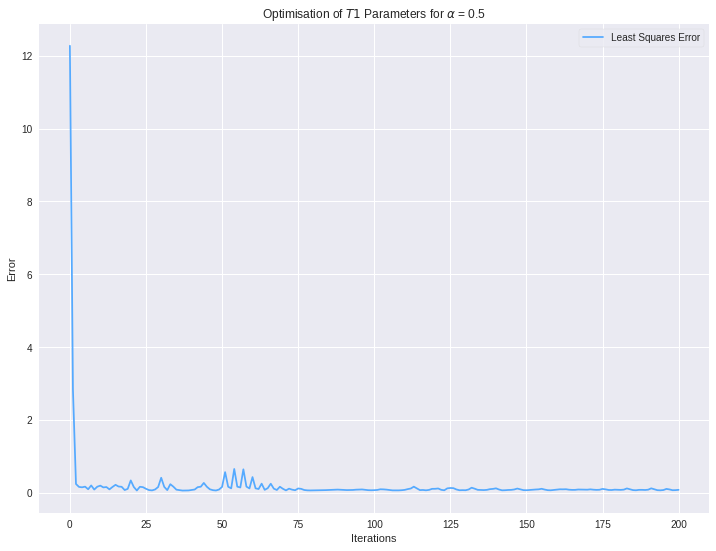

In [85]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(tlst, scorelst_10, label = 'Least Squares Error', color = cool[1])

plt.title('Optimisation of $T1$ Parameters for ' + r'$\alpha$' + ' = ' + str(alpha))
plt.xlabel('Iterations')
plt.ylabel('Error')
# plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

### Plot the fitted results

In [86]:
t1_best_10 = func_t1(xd, init_01, *best_10)

In [87]:
#R2 Regression

np.round(reg([jnp.array(t1mit_lst11_10, dtype=jnp.float64), jnp.array(t1mit_lst01_10, dtype=jnp.float64), jnp.array(t1mit_lst10_10, dtype=jnp.float64), jnp.array(t1mit_lst00_10, dtype=jnp.float64)],
    [t1_best_10[:, 0, 0], t1_best_10[:, 1, 1], t1_best_10[:, 2, 2], t1_best_10[:, 3, 3]]), 2)

99.72

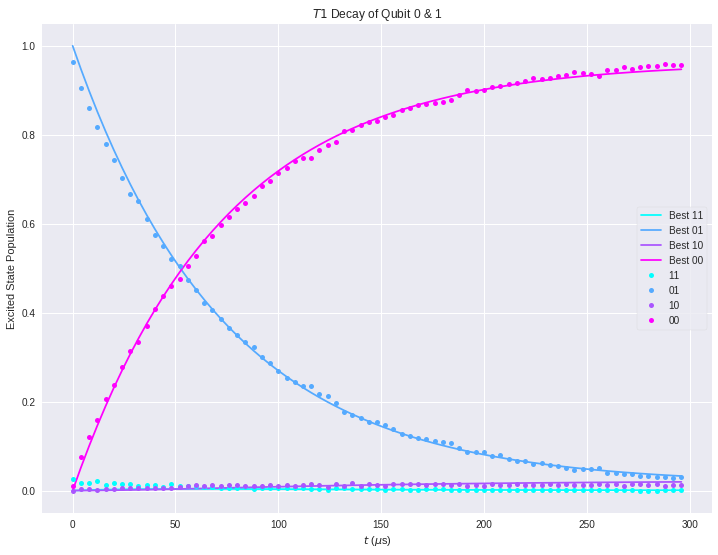

In [88]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1_best_10[:, 0, 0], label = 'Best 11', color = cool[0])
plt.plot(time, t1_best_10[:, 1, 1], label = 'Best 01', color = cool[1])
plt.plot(time, t1_best_10[:, 2, 2], label = 'Best 10', color = cool[2])
plt.plot(time, t1_best_10[:, 3, 3], label = 'Best 00', color = cool[3])

plt.plot(time, t1mit_lst11_10, label = '11', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst01_10, label = '01', marker='.', markersize=10, linestyle='', color = cool[1])
plt.plot(time, t1mit_lst10_10, label = '10', marker='.', markersize=10, linestyle='', color = cool[2])
plt.plot(time, t1mit_lst00_10, label = '00', marker='.', markersize=10, linestyle='', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## $T_1 |01\rangle$

In [89]:
# Define an adam gradient descent optimiser

minfunc_01 = vmap(minmse_01)

scorelst_01 = []
tlst = []

# bounds = jnp.array([w0, w1, g1l[0], g1l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack_01(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bound
    first = x
    best = x
    worst = x
    score = minfunc_01(jnp.array([[x]]))
    # score = minmse(jnp.array([x]))
    scbest = score
    print('f(%s) = %f' % (x, score))

    J = jacrev(minmse_01)

    m = jnp.zeros(len(prms1))
    v = jnp.zeros(len(prms1))

    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]

        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2

        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))

        x = x - alpha * mhat / (sqrt(vhat) + eps)

        for i in range(len(x)):
            if x[i] < 0:
                x = index_update(x, index[i], bound[i])

        if scbest > minmse_01(jnp.array([x])):
            best = x
            scbest = minmse_01(jnp.array([best]))

        # evaluate candidate point
        score = minfunc_01(jnp.array([[x]]))
        # score = minmse_01(jnp.array([x]))
        scorelst_01.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest]

In [90]:
# bnds = prms1
bnds = prmsC
# bnds = best
# bnds = prmsl_hc

In [91]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 200
# steps size
alpha = 0.5
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best_01, score_01 = adam_jack_01(bnds, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best_01, score_01))

f([0.0000000e+00 0.0000000e+00 3.1418673e+01 0.0000000e+00 0.0000000e+00
 3.0472517e+01 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0424436e+01 9.9552593e+00 1.1266179e-16 1.8239736e-16]) = 0.287714
>0 => 20.634300
>1 => 3.231158
>2 => 0.241148
>3 => 0.296566
>4 => 0.297114
>5 => 0.134248
>6 => 0.396223
>7 => 0.070451
>8 => 0.077269
>9 => 0.063636
>10 => 0.067761
>11 => 0.064908
>12 => 0.064546
>13 => 0.061522
>14 => 0.060581
>15 => 0.058463
>16 => 0.053632
>17 => 0.055084
>18 => 0.061733
>19 => 0.067284
>20 => 0.068593
>21 => 0.080766
>22 => 0.066672
>23 => 0.061932
>24 => 0.059532
>25 => 0.057849
>26 => 0.061730
>27 => 0.069715
>28 => 0.066809
>29 => 0.070361
>30 => 0.061997
>31 => 0.056105
>32 => 0.060072
>33 => 0.071748
>34 => 0.077672
>35 => 0.109683
>36 => 0.075016
>37 => 0.054900
>38 => 0.059618
>39 => 0.055759
>40 => 0.073377
>41 => 0.183839
>42 => 0.135616
>43 => 0.105798
>44 => 0.058765
>45 

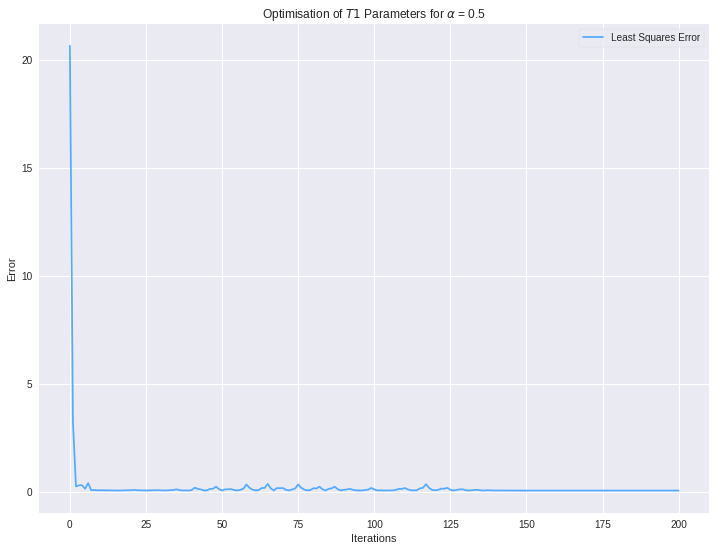

In [92]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(tlst, scorelst_01, label = 'Least Squares Error', color = cool[1])

plt.title('Optimisation of $T1$ Parameters for ' + r'$\alpha$' + ' = ' + str(alpha))
plt.xlabel('Iterations')
plt.ylabel('Error')
# plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

### Plot the fitted results

In [93]:
t1_best_01 = func_t1(xd, init_10, *best_01)

In [94]:
#R2 Regression

np.round(reg([jnp.array(t1mit_lst11_01, dtype=jnp.float64), jnp.array(t1mit_lst01_01, dtype=jnp.float64), jnp.array(t1mit_lst10_01, dtype=jnp.float64), jnp.array(t1mit_lst00_01, dtype=jnp.float64)],
    [t1_best_01[:, 0, 0], t1_best_01[:, 1, 1], t1_best_01[:, 2, 2], t1_best_01[:, 3, 3]]), 2)

99.71

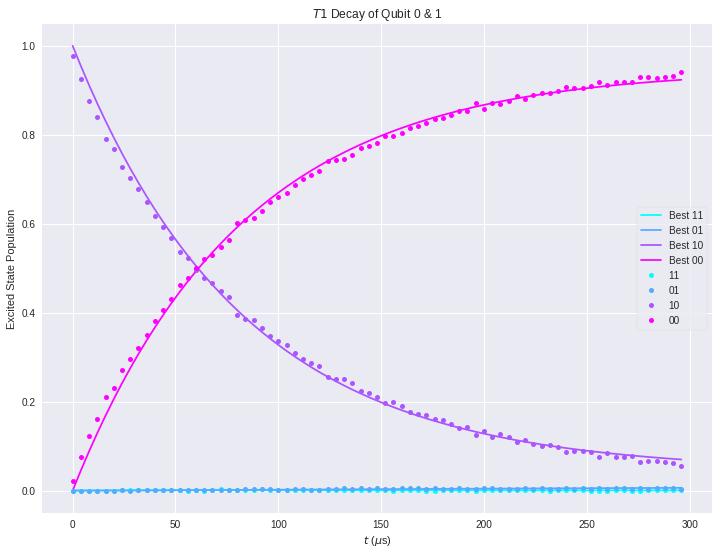

In [95]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1_best_01[:, 0, 0], label = 'Best 11', color = cool[0])
plt.plot(time, t1_best_01[:, 1, 1], label = 'Best 01', color = cool[1])
plt.plot(time, t1_best_01[:, 2, 2], label = 'Best 10', color = cool[2])
plt.plot(time, t1_best_01[:, 3, 3], label = 'Best 00', color = cool[3])

plt.plot(time, t1mit_lst11_01, label = '11', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst01_01, label = '01', marker='.', markersize=10, linestyle='', color = cool[1])
plt.plot(time, t1mit_lst10_01, label = '10', marker='.', markersize=10, linestyle='', color = cool[2])
plt.plot(time, t1mit_lst00_01, label = '00', marker='.', markersize=10, linestyle='', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## $T_1 |11\rangle$

In [96]:
# Define an adam gradient descent optimiser

minfunc_00 = vmap(minmse_00)

scorelst_00 = []
tlst = []

# bounds = jnp.array([w0, w1, g1l[0], g1l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack_00(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bound
    first = x
    best = x
    worst = x
    score = minfunc_00(jnp.array([[x]]))
    # score = minmse(jnp.array([x]))
    scbest = score
    print('f(%s) = %f' % (x, score))

    J = jacrev(minmse_00)

    m = jnp.zeros(len(prms1))
    v = jnp.zeros(len(prms1))

    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]

        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2

        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))

        x = x - alpha * mhat / (sqrt(vhat) + eps)

        for i in range(len(x)):
            if x[i] < 0:
                x = index_update(x, index[i], bound[i])

        if scbest > minmse_00(jnp.array([x])):
            best = x
            scbest = minmse_00(jnp.array([best]))

        # evaluate candidate point
        score = minfunc_00(jnp.array([[x]]))
        # score = minmse_00(jnp.array([x]))
        scorelst_00.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest]

In [97]:
# bnds = prms1
bnds = prmsC
# bnds = best
# bnds = prmsl_hc

In [98]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 200
# steps size
alpha = 0.5
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best_00, score_00 = adam_jack_00(bnds, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best_00, score_00))

f([0.0000000e+00 0.0000000e+00 3.1418673e+01 0.0000000e+00 0.0000000e+00
 3.0472517e+01 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.1541466e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0424436e+01 9.9552593e+00 1.1266179e-16 1.8239736e-16]) = 0.199070
>0 => 38.460854
>1 => 10.353189
>2 => 0.199070
>3 => 0.199070
>4 => 0.199070
>5 => 0.199070
>6 => 0.189411
>7 => 0.458888
>8 => 0.051578
>9 => 0.194201
>10 => 0.085765
>11 => 0.059769
>12 => 0.052238
>13 => 0.058072
>14 => 0.085939
>15 => 0.042865
>16 => 0.044507
>17 => 0.062260
>18 => 0.047438
>19 => 0.035762
>20 => 0.041559
>21 => 0.052197
>22 => 0.050270
>23 => 0.042532
>24 => 0.038139
>25 => 0.035975
>26 => 0.035897
>27 => 0.037470
>28 => 0.040717
>29 => 0.046876
>30 => 0.059909
>31 => 0.094763
>32 => 0.118213
>33 => 0.209634
>34 => 0.184548
>35 => 0.233716
>36 => 0.194955
>37 => 0.283035
>38 => 0.199070
>39 => 0.206879
>40 => 0.162117
>41 => 0.218364
>42 => 0.168790
>43 => 0.190185
>44 => 0.145986
>45

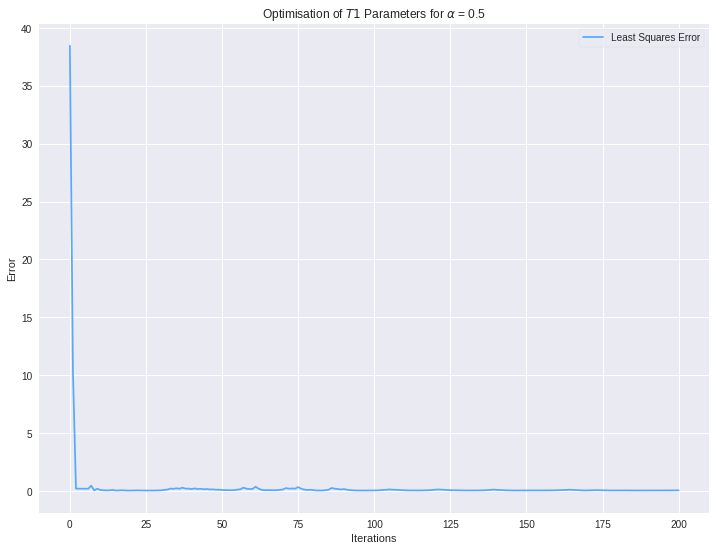

In [99]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(tlst, scorelst_00, label = 'Least Squares Error', color = cool[1])

plt.title('Optimisation of $T1$ Parameters for ' + r'$\alpha$' + ' = ' + str(alpha))
plt.xlabel('Iterations')
plt.ylabel('Error')
# plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

### Plot the fitted results

In [100]:
t1_best_00 = func_t1(xd, init_11, *best_00)

In [101]:
#R2 Regression

np.round(reg([jnp.array(t1mit_lst11_00, dtype=jnp.float64), jnp.array(t1mit_lst01_00, dtype=jnp.float64), jnp.array(t1mit_lst10_00, dtype=jnp.float64), jnp.array(t1mit_lst00_00, dtype=jnp.float64)],
    [t1_best_00[:, 0, 0], t1_best_00[:, 1, 1], t1_best_00[:, 2, 2], t1_best_00[:, 3, 3]]), 2)

-797.65

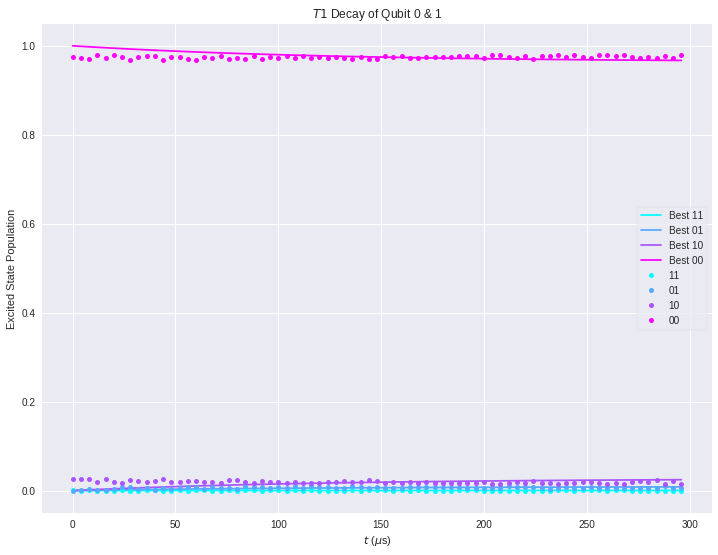

In [102]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1_best_00[:, 0, 0], label = 'Best 11', color = cool[0])
plt.plot(time, t1_best_00[:, 1, 1], label = 'Best 01', color = cool[1])
plt.plot(time, t1_best_00[:, 2, 2], label = 'Best 10', color = cool[2])
plt.plot(time, t1_best_00[:, 3, 3], label = 'Best 00', color = cool[3])

plt.plot(time, t1mit_lst11_00, label = '11', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst01_00, label = '01', marker='.', markersize=10, linestyle='', color = cool[1])
plt.plot(time, t1mit_lst10_00, label = '10', marker='.', markersize=10, linestyle='', color = cool[2])
plt.plot(time, t1mit_lst00_00, label = '00', marker='.', markersize=10, linestyle='', color = cool[3])

plt.title('$T1$ Decay of Qubit 0 & 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [ ]:
rows_t1b_11_00 = zip(time, t1_best_11[:, 0, 0])
rows_t1b_11_10 = zip(time, t1_best_11[:, 1, 1])
rows_t1b_11_01 = zip(time, t1_best_11[:, 2, 2])
rows_t1b_11_11 = zip(time, t1_best_11[:, 3, 3])

with open('Q2_T1_i11_best00.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_11_00:
        writer.writerow(row)

with open('Q2_T1_i11_best10.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_11_10:
        writer.writerow(row)

with open('Q2_T1_i11_best01.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_11_01:
        writer.writerow(row)

with open('Q2_T1_i11_best11.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_11_11:
        writer.writerow(row)

In [ ]:
rows_t1b_01_00 = zip(time, t1_best_01[:, 0, 0])
rows_t1b_01_10 = zip(time, t1_best_01[:, 1, 1])
rows_t1b_01_01 = zip(time, t1_best_01[:, 2, 2])
rows_t1b_01_11 = zip(time, t1_best_01[:, 3, 3])

with open('Q2_T1_i01_best00.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_01_00:
        writer.writerow(row)

with open('Q2_T1_i01_best10.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_01_10:
        writer.writerow(row)

with open('Q2_T1_i01_best01.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_01_01:
        writer.writerow(row)

with open('Q2_T1_i01_best11.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_01_11:
        writer.writerow(row)

In [ ]:
rows_t1b_10_00 = zip(time, t1_best_10[:, 0, 0])
rows_t1b_10_10 = zip(time, t1_best_10[:, 1, 1])
rows_t1b_10_01 = zip(time, t1_best_10[:, 2, 2])
rows_t1b_10_11 = zip(time, t1_best_10[:, 3, 3])

with open('Q2_T1_i10_best00.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_10_00:
        writer.writerow(row)

with open('Q2_T1_i10_best10.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_10_10:
        writer.writerow(row)

with open('Q2_T1_i10_best01.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_10_01:
        writer.writerow(row)

with open('Q2_T1_i10_best11.csv', "w") as a:
    writer = csv.writer(a)
    for row in rows_t1b_10_11:
        writer.writerow(row)

## Extract Parameters

In [103]:
best_11

DeviceArray([0.0000000e+00, 0.0000000e+00, 3.1418673e+01, 0.0000000e+00,
             0.0000000e+00, 3.0472517e+01, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.2654188e+01,
             1.1349442e+01, 1.0650074e-02, 4.5245282e-02], dtype=float32)

In [104]:
best_10

DeviceArray([0.0000000e+00, 0.0000000e+00, 3.1418673e+01, 0.0000000e+00,
             0.0000000e+00, 3.0472517e+01, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.3000344e+01,
             7.0105720e+00, 1.5088975e-02, 2.3842253e-02], dtype=float32)

In [105]:
best_01

DeviceArray([0.0000000e+00, 0.0000000e+00, 3.1418673e+01, 0.0000000e+00,
             0.0000000e+00, 3.0472517e+01, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.3950260e+00,
             1.1054248e+01, 1.2988625e-02, 4.8115417e-02], dtype=float32)

In [106]:
best_00

DeviceArray([0.0000000e+00, 0.0000000e+00, 3.1418673e+01, 0.0000000e+00,
             0.0000000e+00, 3.0472517e+01, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 4.1541466e-03, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 7.9382410e+00,
             7.5033617e+00, 9.4976965e-03, 2.8803241e-02], dtype=float32)

### $\mathcal{H}$

In [107]:
def duff_ham(om0, om1, jc01):
    ham = om0 * sz1 / 2 + om1 * sz2 / 2 + jc01 * (jnp.kron(sp, sm) + jnp.kron(sm, sp))
    return ham

In [108]:
def big_ham(wq1, wq2, jcmat):
    W0 = jnp.array(wq1)
    W1 = jnp.array(wq2)
    jc = jnp.array(jcmat)

    sjs = 0
    ws0 = []
    ws1 = []

    for i in range(3):
        sjs += jnp.dot(sv1[i], jdot(jc, sv2)[i])

    for i in range(3):
        ws0.append(W0[i]/2 * sv1[i])
        ws1.append(W1[i]/2 * sv2[i])
    ws0 = jnp.array(sum(ws0))
    ws1 = jnp.array(sum(ws1))
    return ws0 + ws1 + sjs

In [109]:
H_11 = big_ham(best_11[:3], best_11[3:6], best_11[6:15].reshape(3, 3))
H_11

DeviceArray([[ 30.945595  +0.j,   0.        +0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.47307777+0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,  -0.47307777+0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,   0.        +0.j,
              -30.945595  +0.j]], dtype=complex64)

In [110]:
H_10 = big_ham(best_10[:3], best_10[3:6], best_10[6:15].reshape(3, 3))
H_10

DeviceArray([[ 30.945595  +0.j,   0.        +0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.47307777+0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,  -0.47307777+0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,   0.        +0.j,
              -30.945595  +0.j]], dtype=complex64)

In [111]:
H_01 = big_ham(best_01[:3], best_01[3:6], best_01[6:15].reshape(3, 3))
H_01

DeviceArray([[ 30.945595  +0.j,   0.        +0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.47307777+0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,  -0.47307777+0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,   0.        +0.j,
              -30.945595  +0.j]], dtype=complex64)

In [112]:
H_00 = big_ham(best_00[:3], best_00[3:6], best_00[6:15].reshape(3, 3))
H_00

DeviceArray([[ 30.945595  +0.j,   0.        +0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.47307777+0.j,   0.        +0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,  -0.47307777+0.j,
                0.        +0.j],
             [  0.        +0.j,   0.        +0.j,   0.        +0.j,
              -30.945595  +0.j]], dtype=complex64)

In [113]:
H_claim = duff_ham(w0, w1, j01)
H_claim

DeviceArray([[ 3.0945595e+10+0.j,  0.0000000e+00+0.j,  0.0000000e+00+0.j,
               0.0000000e+00+0.j],
             [ 0.0000000e+00+0.j,  4.7307776e+08+0.j,  8.3082930e+06+0.j,
               0.0000000e+00+0.j],
             [ 0.0000000e+00+0.j,  8.3082930e+06+0.j, -4.7307776e+08+0.j,
               0.0000000e+00+0.j],
             [ 0.0000000e+00+0.j,  0.0000000e+00+0.j,  0.0000000e+00+0.j,
              -3.0945595e+10+0.j]], dtype=complex64)

### $\omega_0$

In [114]:
best_11[:3] * unts.GHz

<Quantity [ 0.      ,  0.      , 31.418673] GHz>

In [115]:
best_10[:3] * unts.GHz

<Quantity [ 0.      ,  0.      , 31.418673] GHz>

In [116]:
best_01[:3] * unts.GHz

<Quantity [ 0.      ,  0.      , 31.418673] GHz>

In [117]:
best_00[:3] * unts.GHz

<Quantity [ 0.      ,  0.      , 31.418673] GHz>

In [118]:
w0 / 1e9 * unts.GHz

<Quantity 31.41867315 GHz>

### $\omega_1$

In [119]:
best_11[3:6] * unts.GHz

<Quantity [ 0.      ,  0.      , 30.472517] GHz>

In [120]:
best_10[3:6] * unts.GHz

<Quantity [ 0.      ,  0.      , 30.472517] GHz>

In [121]:
best_01[3:6] * unts.GHz

<Quantity [ 0.      ,  0.      , 30.472517] GHz>

In [122]:
best_00[3:6] * unts.GHz

<Quantity [ 0.      ,  0.      , 30.472517] GHz>

In [123]:
w1 / 1e9 * unts.GHz

<Quantity 30.47251673 GHz>

### $\vec{J}$

In [124]:
best_11[6:15].reshape(3, 3)

DeviceArray([[0.00415415, 0.        , 0.        ],
             [0.        , 0.00415415, 0.        ],
             [0.        , 0.        , 0.        ]], dtype=float32)

In [125]:
jnp.linalg.norm(best_11[6:15])

DeviceArray(0.00587485, dtype=float32)

In [126]:
best_10[6:15].reshape(3, 3)

DeviceArray([[0.00415415, 0.        , 0.        ],
             [0.        , 0.00415415, 0.        ],
             [0.        , 0.        , 0.        ]], dtype=float32)

In [127]:
jnp.linalg.norm(best_10[6:15])

DeviceArray(0.00587485, dtype=float32)

In [128]:
best_01[6:15].reshape(3, 3)

DeviceArray([[0.00415415, 0.        , 0.        ],
             [0.        , 0.00415415, 0.        ],
             [0.        , 0.        , 0.        ]], dtype=float32)

In [129]:
jnp.linalg.norm(best_01[6:15])

DeviceArray(0.00587485, dtype=float32)

In [130]:
best_00[6:15].reshape(3, 3)

DeviceArray([[0.00415415, 0.        , 0.        ],
             [0.        , 0.00415415, 0.        ],
             [0.        , 0.        , 0.        ]], dtype=float32)

In [131]:
jnp.linalg.norm(best_00[6:15])

DeviceArray(0.00587485, dtype=float32)

In [132]:
j01 * 1e-6

8.308293226045198

### $T_{1,0}$

In [133]:
(1/best_11[15] * unts.ms).to(unts.us)

<Quantity 79.0252164 us>

In [134]:
(1/best_10[15] * unts.ms).to(unts.us)

<Quantity 76.92103833 us>

In [135]:
(1/best_01[15] * unts.ms).to(unts.us)

<Quantity 417.53199697 us>

In [136]:
(1/best_00[15] * unts.ms).to(unts.us)

<Quantity 125.97249448 us>

In [137]:
(t1c[0] * unts.s).to(unts.us)

<Quantity 95.9284589 us>

### $T_{1,1}$

In [138]:
(1/best_11[16] * unts.ms).to(unts.us)

<Quantity 88.1100595 us>

In [139]:
(1/best_10[16] * unts.ms).to(unts.us)

<Quantity 142.64170825 us>

In [140]:
(1/best_01[16] * unts.ms).to(unts.us)

<Quantity 90.4629603 us>

In [141]:
(1/best_00[16] * unts.ms).to(unts.us)

<Quantity 133.27360153 us>

In [142]:
(t1c[1] * unts.s).to(unts.us)

<Quantity 100.44941155 us>

### Temperature 0

In [143]:
T(jnp.linalg.norm(best_11[:3]) * 1e9, best_11[17]).to(unts.mK)

<Quantity 52.71131173 mK>

In [144]:
T(jnp.linalg.norm(best_10[:3]) * 1e9, best_10[17]).to(unts.mK)

<Quantity 57.01981485 mK>

In [145]:
T(jnp.linalg.norm(best_01[:3]) * 1e9, best_01[17]).to(unts.mK)

<Quantity 55.08513376 mK>

In [146]:
T(jnp.linalg.norm(best_00[:3]) * 1e9, best_00[17]).to(unts.mK)

<Quantity 51.43054575 mK>

### Temperature 1

In [147]:
T(jnp.linalg.norm(best_11[3:6]) * 1e9, best_11[18]).to(unts.mK)

<Quantity 74.12832975 mK>

In [148]:
T(jnp.linalg.norm(best_10[3:6]) * 1e9, best_10[18]).to(unts.mK)

<Quantity 61.9055666 mK>

In [149]:
T(jnp.linalg.norm(best_01[3:6]) * 1e9, best_01[18]).to(unts.mK)

<Quantity 75.54206997 mK>

In [150]:
T(jnp.linalg.norm(best_00[3:6]) * 1e9, best_00[18]).to(unts.mK)

<Quantity 65.09453803 mK>

# Configuration

In [151]:
import qiskit.tools.jupyter
%qiskit_version_table